# The cavity flow problem

* EC, Mar 2022

### Notions addressed

* Resolution of the 2D, elliptic cavity flow problem

### Problem statement

The steady flow is within a cavity bounded with walls at the bottom ($y=0$) and both sides ($x=0$ and $x=L_x$). The cavity is open at the top $y=L_y$ where the fluid velocity is forced to $U=U_0$ along the $x$-direction. After some computation, the final equations are:

$$ \Delta {\psi} ~= ~- \omega $$

$$ \Delta {\bf \omega}~ = ~\frac{1}{\nu}~ \left( ~\frac{\partial \psi}{\partial y}~\frac{\partial \omega}{\partial x} ~- ~\frac{\partial \psi}{\partial x} ~\frac{\partial \omega}{\partial y} ~\right)   $$

where:

* $\psi$ is the stream function, i.e. $u=\frac{\partial \psi}{\partial y}$ and $v= -  \frac{\partial \psi}{\partial x}$
* $\omega$ is vorticity, $\omega = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}$
* $\nu$ is kinematic viscosity

The boundary conditions are impermeability and adherence: all velocities are 0 at the boundaries. The consequences for $\psi$ and $\omega$ are:

$$\psi=0 \quad \mbox{at the boundaries.} $$

$$ \omega(0,y) = - \frac{\partial^2 \psi}{\partial x^2} (0,y)$$

$$ \omega(L_x,y) = - \frac{\partial^2 \psi}{\partial x^2} (L_x,y)$$

$$ \omega(x,0) = - \frac{\partial^2 \psi}{\partial y^2} (x,0)$$

$$ \omega(x,L_y) = - \frac{\partial^2 \psi}{\partial y^2} (x,L_y)$$

Note that for the implementation of the elliptic solver, the problem can be formulated as a single elliptic equation with vector composed of $(\psi, \omega)$.



## 0. Import useful packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D

## 1. Spatial domain

In [3]:
Utop, Nuv = 1, 1  # Velocity on top, Kinematic viscosity
Lx, Ly = 1.5, 1
Nx, Ny = 51, 31
xdom, ydom = np.linspace(0,Lx,Nx), np.linspace(0,Ly,Ny)
dx, dy = xdom[1]-xdom[0], ydom[1]-ydom[0]
ymesh, xmesh = np.meshgrid(ydom, xdom)

In [4]:
xmesh.shape

(51, 31)

## 2. Resolution

We define functions to make the main resolution loop more concise.

In [5]:
def solve_strf(stf, vor):
    """implement SOR iteration for the stream function equation."""
    stf[:,0], stf[0,:], stf[-1,:], stf[:,-1] = 0, 0, 0, 0
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            stf[i,j] = (1 - omega ) * stf[i,j] \
                     + ( alpha * ( stf[i-1,j] + stf[i+1,j] ) \
                     +  beta * ( stf[i,j-1] + stf[i,j+1] ) \
                     + vor[i,j] ) * omega / ( 2 * (alpha+beta) )
    return stf

def build_forcing_vort(stf, vor):
    """Build right-hand side term of vorticity equation"""
    forcing = np.zeros_like(xmesh)
    sx = 0.5 * ( np.roll(stf,-1,axis=0) - np.roll(stf,1,axis=0) ) / dx
    vx = 0.5 * ( np.roll(vor,-1,axis=0) - np.roll(vor,1,axis=0) ) / dx
    sy = 0.5 * ( np.roll(stf,-1,axis=1) - np.roll(stf,1,axis=1) ) / dy
    vy = 0.5 * ( np.roll(vor,-1,axis=1) - np.roll(vor,1,axis=1) ) / dy
    forcing = ( sy*vx - sx*vy ) / Nuv
    forcing[0,:], forcing[-1,:], forcing[:,0], forcing[:,-1] = 0, 0, 0, 0
    return forcing

def solve_vort(stf, vor):
    """implement SOR iteration for the vorticity equation."""
    vor[-1,:] = -2*alpha*stf[-2,:]
    vor[0,:] = -2*alpha*stf[1,:]
    vor[:,0] = -2*beta*stf[:,1]
    vor[:,-1] = -2*beta*stf[:,-2] - 2*Utop/dy
    forcing = build_forcing_vort(stf, vor)
    for i in range(1, Nx-1):
        for j in range(1, Ny-1):
            vor[i,j] = (1 - omega ) * vor[i,j] \
                     + ( alpha * ( vor[i-1,j] + vor[i+1,j] ) \
                     +  beta * ( vor[i,j-1] + vor[i,j+1] ) \
                     - forcing[i,j] ) * omega / ( 2 * (alpha+beta) )
    return vor

In [6]:
vort = np.zeros_like(xmesh)    # vorticity
strf = np.zeros_like(xmesh)    # stream function

kmax, k = 1000, 0
eps, err = 1e-6, 10
omega = 1.5   # Over-relaxation for 1<omega<2
alpha, beta = 1/(dx*dx), 1/(dy*dy)

while (k<kmax) and (err>eps):
    strf_tmp = np.copy(strf)
    vort_tmp = np.copy(vort)
    strf = solve_strf(strf, vort)
    vort = solve_vort(strf, vort)
    err = np.sqrt( np.mean( np.square(vort-vort_tmp) ) )
    k += 1

print(("iterations: ", k))
print(("error: ", err))

('iterations: ', 418)
('error: ', 9.781945315748499e-07)


In [7]:
# This function is used only for the plots
def compute_uv(strf):
    """Compute u and v from streamfunction.
    Implement a centered scheme and the specific boundary conditions of the cavity problem."""
    u = 0.5 * ( np.roll(strf,-1,axis=1) - np.roll(strf,1,axis=1) ) / dy
    u[0,:], u[-1,:], u[:,0], u[:,-1]  = 0, 0, 0, Utop 
    v = - 0.5 * ( np.roll(strf,-1,axis=0) - np.roll(strf,1,axis=0) ) / dx
    v[0,:], v[-1,:], v[:,0], v[:,-1]  = 0, 0, 0, 0
    return u, v

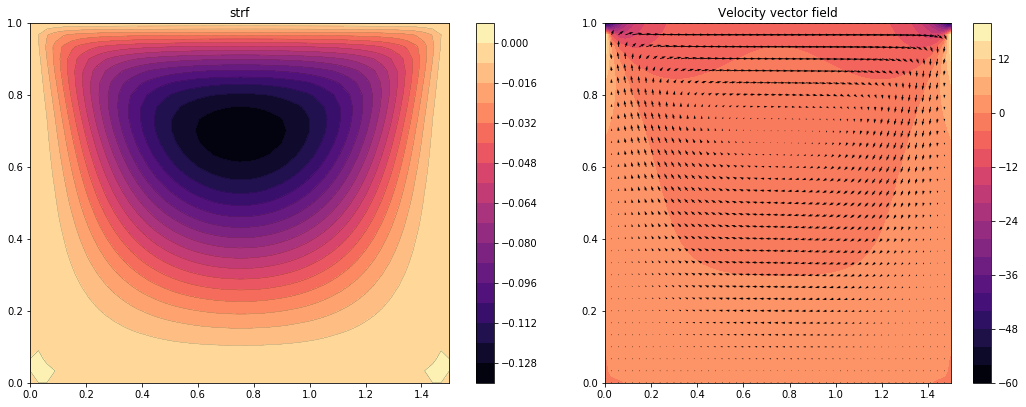

In [8]:
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_axes([0, 0, 0.52, 1])    # [left, bottom, width, height] 
ax2 = fig.add_axes([0.57, 0, 0.43, 1])

vmin, vmax = -1, 1
ax1.contour(xmesh, ymesh, strf, 20, colors='black', linewidths = 0.2)
pc0=ax1.contourf(xmesh, ymesh, strf, 20, cmap = "magma")
ax1.set_title("strf")
fig.colorbar(pc0, ax=ax1)


u, v = compute_uv(strf)

pc0=ax2.contourf(xmesh, ymesh, vort, 20, cmap = "magma")
slsp = 1  # slicing step
ax2.quiver(xmesh[::slsp,::slsp], ymesh[::slsp,::slsp], u[::slsp,::slsp], v[::slsp,::slsp])
ax2.set_title("Velocity vector field")
fig.colorbar(pc0, ax=ax2)